In [1]:
from xml.dom import minidom
import re
import pandas as pd
import sys
import pickle
import numpy as np
#from nltk.stem import PorterStemmer
#from nltk.tokenize import sent_tokenize, word_tokenize
#ps = PorterStemmer()

### Preprocessing steps

1. Stem regular verbs
2. Stem irregular verbs
3. Removing minor words
4. Removing tags and garbage charecters with rtegular expression.

*All of these is implemented with raw python (without nltk)

In [2]:
root='Dataset/'
f=open(root+'Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')

f=open(root+'verbs.txt','r')
verbs=f.read()
f.close()
verbs=verbs.split('\n')

irr=pd.read_csv(root+'irr_verbs.txt',delimiter=',',names=['root','past','past_par'])
verb_root=list(irr['root'])
past=list(irr['past'])
past_pp=list(irr['past_par'])


def stem_regular_verb(word):
    if len(word)<=3:
        return word
    if word[-2:]=='es':
        if word[:-2] in verbs:
            word=word[:-2]

    elif word[-1:]=='s':
        if word[:-1] in verbs:
            word=word[:-1]
            
    elif word[-3:]=='ing':
        if word[:-3] in verbs:
            word=word[:-3]
        if word[:-4] in verbs:
            word=word[:-4]
        else:
            word=word[:-3]
    
    elif word[-2:]=='ed':
        if word[:-2] in verbs:
            word=word[:-2]
        elif word[:-1] in verbs:
            word=word[:-1]
    #word=stem_irregular(word)
    return word
def stem_simple(word):
    if word[-2:]=='es':
            word=word[:-2]   
    elif word[-1:]=='s':
            word=word[:-1]
    elif word[-3:]=='ing':
            word=word[:-3]
    
    elif word[-2:]=='ed':
            word=word[:-2]
    return word

def stem_irregular_verb(word):
        if word in past:
            ind=past.index(word)
            word=verb_root[ind]
        elif word in past_pp:
            ind=past_pp.index(word)
            word=verb_root[ind]
        return word
def stem_word(word):
    temp=word
    word=stem_regular_verb(word)
    word=stem_irregular_verb(word)
    #word=ps.stem(word)
    if(len(word)<=1):
        return temp
    return word   
def remove_minor_words(wordmap,word_count,min_occurance):
    words=list(wordmap.keys())
    freq=list(wordmap.values())
    word_df=pd.DataFrame(words,index=list(wordmap.values()),columns=['words'])
    word_df=word_df.sort_index()
    word_df['freq']=wc
    word_df=word_df.sort_values('freq',ascending=False)
    mask=word_df['freq']<=min_occurance
    word_df=word_df[mask]
    
    ss_words=(list(word_df['words']))
    print('initial length of wordmap :',len(wordmap))
    for word in ss_words:
        del wordmap[word]
    
    _wordmap={}
    ind=0
    for word in wordmap.keys():
        _wordmap[word]=ind
        ind+=1
    print('reduced length of wordmap :',len(_wordmap))
    return _wordmap
def remove_tags(doc):
    text=doc.lower()
    #text=re.sub('\n',' ',text)
    #text=re.sub('-',' ',text)
    #text=re.sub('[()?.@*#&!,$]','',text)
    #text=re.sub('[\']','',text)
    #text=re.sub('[^a-z0-9]',' ',text)
    #words=text.split(' ')
    text=re.sub('<[^<>]+>',' ',text)
    words=re.findall('\w+',text)
    return words
def pre_process(topics,max_doc,root):
    index=0
    labels=[]
    ln=0
    labeled_docs={}
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        documents = mydoc.getElementsByTagName('row')
        doc_count=0
        docs=[]
        for doc in documents:
            doc=doc.attributes['Body'].value
            if len(doc)<5:
                continue
            words = remove_tags(doc)
            ln+=len(words)
            docs.append(words)
            labels.append(topic)
            doc_count+=1
            if doc_count>=max_doc:
                break
        labeled_docs[topic]=docs
    return labeled_docs,ln

In [3]:
root_train='Dataset/Training/'
root_test='Dataset/Test/'
f=open(root+'Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')
max_docs_train=200
max_docs_test=60
log=False
root_train='Dataset/Training/'
#topics=['3d_Printer','Anime','Arduino']
topics=['3d_Printer','Coffee','Chess']
#topics=['3d_Printer','Coffee','Chess','Astronomy','Law']
train_docs,ln=pre_process(topics,max_docs_train,root_train)
test_docs,ln=pre_process(topics,max_docs_test,root_test)
print(ln)

3d_Printer
Coffee
Chess
3d_Printer
Coffee
Chess
26024


### Word to Vector
1. Creating dictionary of words from dataset
    
       Function make dictionary
    
2. Creating Vector for every class i.e
    
       Function Vectorize sequence
    
    if class -- > A
    
              Vector A -- > prob_of_word1,prob_of_word2, prob_of_word3 ...... prob_of_wordn
    
    if class -- > B
       
              Vector B -- > prob_of_word1,prob_of_word2, prob_of_word3 ...... prob_of_wordn

In [4]:
def make_dictionary(topics,max_doc,all_docs):
    index=0
    wordmap={}
    word_count=[]
    for topic in topics:
        print(topic)
        doc_count=0
        docs=all_docs[topic]
        for doc in docs:
            for word in doc:
                if word in s_words or len(word)<=1:
                    continue
                word=stem_word(word)
                if word not in wordmap:
                    wordmap[word]=index
                    word_count.append(int(1))
                    index=index+1
                elif word in wordmap:
                    ind=wordmap[word]
                    word_count[ind]=int(word_count[ind])+1
    return wordmap,word_count

def vectorize_seq_nb(topics,max_doc,wordmap,all_docs,doc_per_vect='all'):
    if doc_per_vect=='single':
        n_row=len(topics)*(max_doc)
    if doc_per_vect=='all':
        n_row=len(topics)
    vectors=np.zeros((n_row,len(wordmap)),dtype=np.float64)
    vct_label=[]
    row=0
    for topic in topics:
        print(topic)
        doc_count=0
        docs=all_docs[topic]
        for doc in docs:
            for word in doc:
                #word=ps.stem(word)
                if word in wordmap:
                    ind=wordmap[word]
                    vectors[row,ind]=vectors[row,ind]+1
            word_list.append(doc)
            if doc_per_vect=='single':
                vct_label.append(topic)
                row=row+1
        if doc_per_vect=='all':
            vct_label.append(topic)
            row=row+1
    return vectors,vct_label

In [5]:
word_list=[]
min_occurance=int(max_docs_train/200)
print('Making dictionary :')
wordmap,wc=make_dictionary(topics,max_docs_train,train_docs)
#print('Removing minor words:')
#wordmap=remove_minor_words(wordmap,wc,min_occurance)
print('Vectorizing Sequence:')
vectors,vct_labels=vectorize_seq_nb(topics,max_docs_train,wordmap,train_docs)
print(len(wordmap))

Making dictionary :
3d_Printer
Coffee
Chess
Vectorizing Sequence:
3d_Printer
Coffee
Chess
6035


### Naive Bayes Function

In [6]:
test_vectors,true_lbs=vectorize_seq_nb(topics,max_docs_test,wordmap,test_docs,doc_per_vect='single')
def naive_bayes(test_vector,vectors,vct_labels,alpha):
    probs=[]
    maxm=0
    lb=''
    vct=0
    _vectors=vectors.copy()
    total_word_all=np.sum(_vectors)#len(wordmap)
    for row in range(len(_vectors)):
        total_word=np.sum(_vectors[row])
        _vectors[row]=_vectors[row]+alpha
        _vectors[row]=_vectors[row]/(total_word+alpha*total_word_all)
    #norm_value=np.mean(_vectors)
    norm_value=(1000.0-0)/(np.max(_vectors)-np.min(_vectors))
    for row in range(len(_vectors)):
        vect=_vectors[row].copy()
        vect=np.exp(vect)
        #vect=vect*norm_value#1000#total_word_all#np.sum(_vectors)
        vect[test_vector==0]=1.0
        #test_vector_zero_mask=np.array(test_vector==0,dtype=np.uint8)
        #test_vector_one_mask=np.array(test_vector!=0,dtype=np.uint8)
        #vect=test_vector_one_mask*vectors[row]+test_vector_zero_mask
        prob=np.prod(vect)
        #prob=1
        #for p in range(len(vect)):
        #    if vect[p]!=1:
        #        prob*=(vect[p]*1000)
        #prob=np.sum(vect)
        probs.append(prob)
        if prob>=maxm:
            maxm=prob
            lb=vct_labels[row]
    return probs,lb
print(len(test_vectors))

3d_Printer
Coffee
Chess
180


### Training with alpha values from 0.00001 to 0.1

In [7]:
import time
from tqdm import tqdm
alph=10
no_topics=len(topics)
tot_doc=no_topics*max_docs_train
tot_doc_test=no_topics*max_docs_test
acc_log=''
acc_log+='******************************************************************\n'
acc_log+=str(topics)+'\n'
acc_log+=str(['no_topic','train doc per topic','train_doc','test doc per topic','test_doc','word map'])+'\n'
acc_log+=str([no_topics,max_docs_train,tot_doc,max_docs_test,tot_doc_test,str(len(wordmap))])+'\n'
acc_log+='******************************************************************\n'
head=acc_log
acc_log+=str(['alpha','accuracy','time'])+'\n'

lst=np.array([1],dtype=np.float64)
acc_list=[]
alph_list=[]
alpha_list=np.concatenate((lst/100000,lst/10000,lst/1000,lst/100,lst/10))
alpha_list=np.round(alpha_list,5)
#alpha_list=[.000001]
for al in alpha_list:
    T=time.time()
    acc=0
    alpha=al
    for i in tqdm(range(len(test_vectors))):
        pred,pred_label=naive_bayes(test_vectors[i],vectors,vct_labels,alpha)
        #print(true_lbs[i],pred_label)
        #print(pred)
        if pred_label==true_lbs[i]:
            acc=acc+1
        else:
            pass
            #print('no')
            #print(pred)
        #print('res','pred',lb,'true',true_lbs[i],i+1,acc)
    T=time.time()-T
    accuracy=acc/(i+1)
    acc_list.append(accuracy)
    alph_list.append(alpha)
    print('alpha: ',alpha,'acc :',accuracy)
    acc_log+=(str([alpha,accuracy,T])+'\n')
    
acc_log=re.sub('[\[\]]','',acc_log)
acc_list=np.array(acc_list,dtype=np.float64)
alpha_list=np.array(alpha_list,dtype=np.float64)
max_acc=np.max(acc_list)
avg_acc=np.mean(acc_list)
max_alpha=alph_list[np.argmax(acc_list)]
head+=str(['alpha','accuracy','avg_acc'])+'\n'
result=(str([max_alpha,max_acc,avg_acc])+'\n')
if log==True:
    f=open('NB/NB_mod.csv','a')
    f.write(head+result)
    f.close()
    f=open('Report_KNN_NB/NB_topic_2_200_60_no_corr.txt','a')
    f.write(acc_log)
    f.close()

    #print(pred)

  0%|          | 0/180 [00:00<?, ?it/s]

alpha:  1e-05 acc : 0.9722222222222222
alpha:  0.0001 acc : 0.9722222222222222


100%|██████████| 180/180 [00:00<00:00, 2154.52it/s]

alpha:  0.001 acc : 0.9722222222222222
alpha:  0.01 acc : 0.9722222222222222
alpha:  0.1 acc : 0.9666666666666667


In [8]:
import pandas as pd
_result_log=pd.DataFrame(data={},columns=['true','pred','right','wrong'])

for i in range(len(test_vectors)):
        pred,pred_label=naive_bayes(test_vectors[i],vectors,vct_labels,max_alpha)
        _result_log.loc[i,'true']=true_lbs[i]
        _result_log.loc[i,'pred']=pred_label
        
        if pred_label==true_lbs[i]:
            acc=acc+1
            _result_log.loc[i,'right']=1
            _result_log.loc[i,'wrong']=0
        else :
            _result_log.loc[i,'right']=0
            _result_log.loc[i,'wrong']=1
        
       

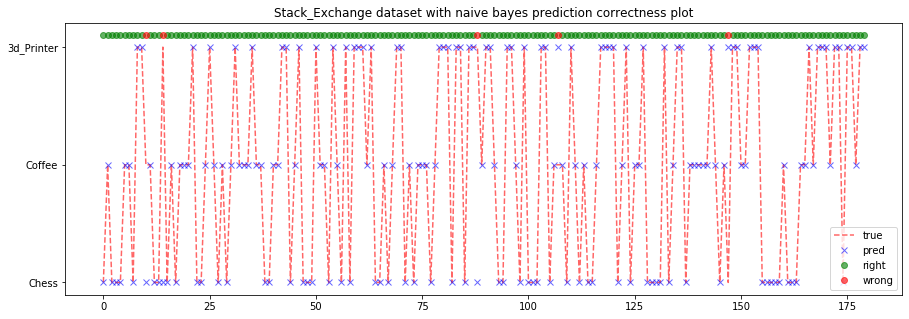

In [16]:
from matplotlib import pyplot as plt
#plt.plot(result_log[['right','wrong']])
result_log=_result_log.sample(frac=1).reset_index()
dataset = 'Stack_Exchange'
fig=plt.figure(figsize=(15,5))
plt.plot(result_log.loc[:,'true'],'r--',alpha=0.6)
plt.plot(result_log.loc[:,'pred'],'bx',alpha=0.6)
plt.plot(result_log.loc[:,'right'][result_log.loc[:,'right']==1]+1.1,'go',alpha=0.6)
plt.plot(result_log.loc[:,'right'][result_log.loc[:,'right']==0]+2.1,'ro',alpha=0.6)
#plt.plot(result_log.loc[:100,'right'],'go',alpha=0.3)
plt.legend(['true','pred','right','wrong'])
plt.title(dataset+' dataset with naive bayes prediction correctness plot')# \n right : 1 \n wrong : 0')
plt.savefig(dataset+'_NB_pred.jpg')
plt.show()

----------------------
label Chess
precision 0.9365079365079365
recall 0.9833333333333333
----------------------
----------------------
label Coffee
precision 0.9508196721311475
recall 0.9666666666666667
----------------------
----------------------
label 3d_Printer
precision 0.9508196721311475
recall 0.9666666666666667
----------------------
Over All Accuracy :  0.9722222222222222


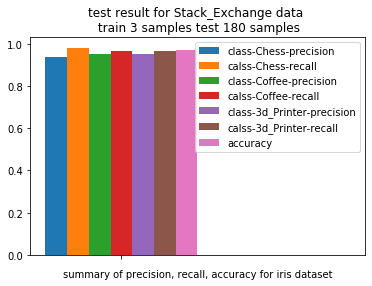

In [10]:
total=len(result_log)
acc=result_log.right.sum()#,len(result_log)
accuracy=acc/total
labels=result_log['true'].unique()
ldf=pd.DataFrame(data={},index=[' '])
precisions={}
recalls={}
for label in labels:
    true_ind=result_log['true']==label
    false_ind=result_log['true']!=label
    Yes=result_log.loc[true_ind]
    No=result_log.loc[false_ind]
    tp=Yes.right.sum()
    tn=Yes.wrong.sum()
    fn=No.right.sum()
    fp=No.wrong.sum()
    recall=tp/(tp+tn)
    precision=tp/(tp+fp)
    precisions[label]=precision
    recalls[label]=recall
    print('----------------------')
    print('label',label)
    print('precision',precision)
    print('recall',recall)
    print('----------------------')
print('Over All Accuracy : ',accuracy)

df=pd.DataFrame({},index=[' '])
#fig=plt.figure(figsize=(10,10))
for label in result_log['true'].unique():
    df['class-'+str(label)+'-precision']=[precisions[label],]
    df['calss-'+str(label)+'-recall']=[recalls[label],]
df['accuracy']=accuracy 
df.plot.bar()
plt.xlim(-.3,.8)
plt.title('test result for ' +dataset+ ' data \n '+'train '+str(len(vectors))+' samples test '+str(len(result_log))+' samples')
plt.xlabel('summary of precision, recall, accuracy for iris dataset')
plt.savefig(dataset+'_NB.png')
plt.show()

### Result

In [11]:
print(head)
print(result)

******************************************************************
['3d_Printer', 'Coffee', 'Chess']
['no_topic', 'train doc per topic', 'train_doc', 'test doc per topic', 'test_doc', 'word map']
[3, 200, 600, 60, 180, '6035']
******************************************************************
['alpha', 'accuracy', 'avg_acc']

[1e-05, 0.9722222222222222, 0.971111111111111]



### Extra experiments - Just for debugging

In [12]:
1.0e-323==0.0

False

In [13]:
words=list(wordmap.keys())
freq=list(wordmap.values())
word_df=pd.DataFrame(words,index=list(wordmap.values()))
word_df=word_df.sort_index()
word_df['freq']=wc
word_df=word_df.sort_values('freq',ascending=False)
print(word_df[0:50])
#print(len(vectors))

              0  freq
3048     coffee   560
39        print   323
10          use   181
2570      chess   163
425       water   157
13         like   143
40         time   141
16      printer   127
2147       game   124
3165   caffeine   120
4956       king   119
83     filament   115
368        open   115
49         used   113
140        make   108
899       moves   105
3050      beans   105
3058       brew   103
15           3d   103
294        good   100
535         way    97
4963     player    97
3123      roast    92
74           us    90
0            ve    89
4947       pawn    87
27         need    86
257        play    85
75          abs    84
645        just    83
3052   espresso    82
2811      white    80
175       parts    78
2224        cup    76
703     machine    76
32         know    74
85     material    74
179        does    73
76          pla    72
353     process    72
34        layer    71
162         don    71
5055      queen    66
92    different    66
2812      

[35. 63. 16. ...  0.  0.  0.]


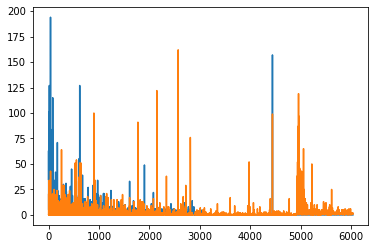

['3d_Printer', 'Coffee', 'Chess']
6035


In [14]:
from matplotlib import pyplot as plt
print((vectors[0]))
x=range(len(vectors[0]))
plt.plot(x,vectors[0])
plt.plot(x,vectors[2])
#plt.plot(x,vectors[2])
plt.show()
print(vct_labels)
print(len(wordmap))
#no stem 500 20599 
#stem 500 14883

In [15]:
def eucl_dis(test_vector,vectors):
    h_dists=[]
    for vector in vectors:
        vect=np.array(vector[:-2])
        vect[vect>1]=1
        label=vector[-1]
        test_vect=np.array(test_vector)
        dist=np.abs(vect-test_vect)
        #dist=np.sum(dist)
        h_dists.append([dist,label])
    return h_dists

test_vector=vectors[0][:-2]
vecto=[vectors[0],vectors[1]]
h_dists=cos_dis(test_vector,vecto)
#h_df=pd.DataFrame(h_dists)
#h_df=h_df.sort_values(0)
print(h_dists)
#print((vectors[15]))

NameError: name 'cos_dis' is not defined

In [ ]:
raw='I am hasib\n,i "am" a student() so? @i do& my-duties! porp. and' 
#text=re.sub('\n',' ',raw)
text=raw.lower()
text=re.sub('[^a-z0-9]',' ',text)
#text=re.sub('-',' ',text)
#text=re.sub('[\'"]','',text)
#text=re.sub('[()?.@*#&!,$+]','',text)
#print(text.split(' '))

In [ ]:
txt=(str([1,2,3]))
txt=re.sub('[\[\]]','',txt)
print(txt)